In [187]:
import os, glob
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import cv2 as cv
import cvxpy as cvx
import qpsolvers as qp
import sklearn.svm as svm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [188]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [206]:
ban_a, app_a, ora_a = np.load('astar-ban_app_ora.npy')
ban_b, app_b, ora_b = np.load('bstar-ban_app_ora.npy')
ban_e, app_e, ora_e = np.load('ecc-ban_app_ora.npy')

ban_features = np.array([ban_a, ban_b, ban_e]).T
app_features = np.array([app_a, app_b, app_e]).T
ora_features = np.array([ora_a, ora_b, ora_e]).T

astars = np.array([ban_a, app_a, ora_a])
bstars = np.array([ban_b, app_b, ora_b])

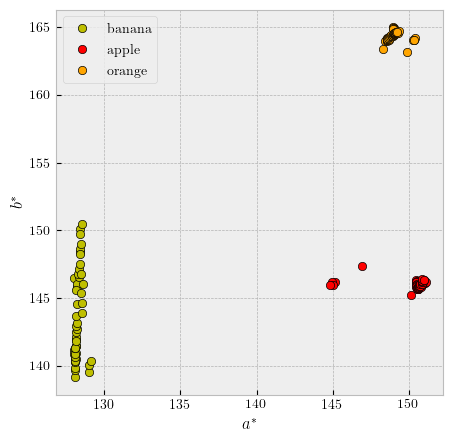

In [207]:
plt.plot(ban_features.T[0], ban_features.T[1], 'yo', mec='k', mew=0.5)
plt.plot(app_features.T[0], app_features.T[1], 'ro', mec='k', mew=0.5)
plt.plot(ora_features.T[0], ora_features.T[1], 'o', color='orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

In [208]:
xdat = np.concatenate((ora_a, app_a))
ydat = np.concatenate((ora_b, app_b))
X = np.column_stack((xdat, ydat))
y = np.concatenate((np.ones(len(ora_a)), -np.ones(len(app_a))))

In [274]:
class SupportVectorMachine:
    def __init__(self, 
                 use_bias=False,                 
                 data_center=False,
                 data_std=False,
                 bias_initializer='ones',
                 tol=1e-12):
        self.use_bias = use_bias
        self.bias_initializer = bias_initializer
        self.data_center = data_center
        self.data_std = data_std
        self.tol = tol
    
    def get_initializer(self):
        if self.bias_initializer == 'ones':
            return np.ones
        elif self.bias_initializer == 'zeros':
            return np.zeros
        elif self.bias_initializer == 'random_uniform':
            return rand.random
        elif self.bias_initializer == 'random_normal':
            return rand.normal
    
    def train(self, X, y, solver='cvxpy', verbose=False):        
        if self.data_center:
            X -= X.mean()
        if self.data_std:
            X /= X.std()
        
        self.X = X
        self.y = y
        self.solver = solver
        
        if self.use_bias:
            self.bias = self.get_initializer()
            X = np.column_stack((self.bias(len(X)), X))
        H = (X.dot(X.T)) * (y.dot(y.T))
        A = -np.identity(len(X))
        a = np.zeros(len(X))
        B = np.vstack((y, np.zeros((len(y)-1, len(y)))))
        b = np.zeros(len(X))
        f = -np.ones(len(X))
        
        if solver == 'cvxpy':
            alpha = cvx.Variable(len(X))
            objective = cvx.Minimize(1/2*cvx.quad_form(alpha, H) + f.T@alpha)
            constraints = [A@alpha <= a, B@alpha == b]
            problem = cvx.Problem(objective, constraints)
            problem.solve(verbose=verbose)
            self.alpha = alpha.value
            self.alpha[self.alpha < self.tol] = 0
        elif solver == 'quadprog':
            self.alpha = qp.solve_qp(H, f, A, a, B, b, solver=solver)
        elif solver == 'libsvm':
            problem = svm.SVC(kernel='linear', verbose=verbose)
            problem.fit(X, y)
            self.clf = problem
            return
            
        w = (self.alpha*y).T.dot(X)
        self.supp_idx = np.squeeze(np.where(self.alpha > self.tol))
        w0 = 1/y[self.supp_idx[0]] - w.T.dot(X[self.supp_idx[0]])
        
        self.w = w
        self.w0 = w0
        self.m = -self.w[1]/self.w[2]
        self.b = -self.w[0]/self.w[2]
        
    def predict(self, X):
        if self.solver is not 'libsvm':
            return np.sign(self.w.T.dot(X) + self.b)
        else:
            return self.clf.predict(X)
    
    def plot_db(self, save=False):
        xmin, xmax = np.min(self.X.T[0])-1, np.max(self.X.T[0])+1
        ymin, ymax = np.min(self.X.T[1])-1, np.max(self.X.T[1])+1
        xx = np.linspace(xmin, xmax, 1000)
        yy = np.linspace(ymin, ymax, 1000)
        X, Y = np.meshgrid(xx, yy)
        Z = self.clf.predict(np.c_[X.ravel(), Y.ravel()])
        Z = Z.reshape(X.shape)
        w = self.clf.coef_[0]
        a = -w[0]/w[1]
        b = self.clf.intercept_[0]
        x = np.linspace(xmin, xmax)
        y = a*x - b/w[1]
        margin = 1/la.norm(self.clf.coef_, 2)
        nav = y - np.sqrt(1 + a**2)*margin
        pav = y + np.sqrt(1 + a**2)*margin

        fig, ax = plt.subplots(1, 1)
        
        if self.solver is not 'libsvm':
            ax.plot(*self.X[self.supp_idx].T, 'o', 
                     mfc='None', mew=1.5, mec='b', ms=10)
            ax.plot(x, self.m*x + self.b, 'k-', lw=1.5)
            legend = ax.legend(*scatter.legend_elements(), 
                               title='classes')
            ax.add_artist(legend)
        else:
            ax.contourf(X, Y, Z, cmap='YlOrRd_r', alpha=0.65)
            ax.plot(x, y, 'k-', lw=1.5)
            ax.plot(x, pav, 'k--', lw=1)
            ax.plot(x, nav, 'k--', lw=1)
            ax.plot(self.clf.support_vectors_.T[0], self.clf.support_vectors_.T[1],
                    'o', mfc='None', mew=1.5, ms=8, mec='b')
            
        scatter = ax.scatter(self.X.T[0], self.X.T[1], 
                             c=self.y, cmap='YlOrRd_r', edgecolors='k', 
                             linewidths=1)
        ax.set_xlabel('$a^*$')
        ax.set_ylabel('$b^*$')
        if save:
            plt.savefig('svm-db.png', dpi=300, bbox_inches='tight')
        plt.show()

[LibSVM]

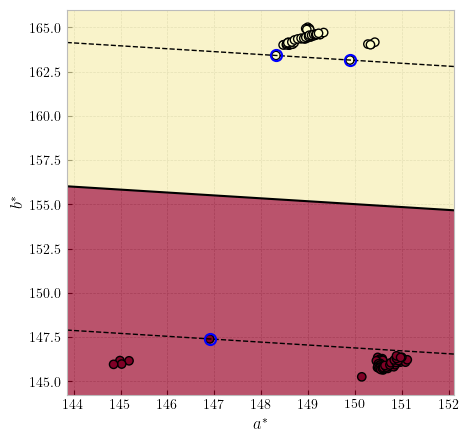

In [275]:
lin = SupportVectorMachine()
lin.train(X, y, solver='libsvm', verbose=True)
lin.plot_db(True)